## Final Project Submission

Please fill out:
* Student name: Christopher Hollman
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [159]:
##importing necessary tools

import pandas as pd
import seaborn as sns
import numpy as np
import os
from glob import glob
from datetime import datetime

In [160]:
## importing files 

csv_files = glob("./zippedData/*.csv.gz")
csv_files

csv_files_dict = {}
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv", "").replace(".", "_")
    filename_df = pd.read_csv(filename, index_col=0)
    csv_files_dict[filename_cleaned] = filename_df
rt_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", delimiter='\t')
rt_reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", delimiter='\t',encoding='latin1')
imdb_title_basics = csv_files_dict['imdb_title_basics_gz']
tn_movie_budgets = csv_files_dict['tn_movie_budgets_gz']
imdb_title_ratings = csv_files_dict['imdb_title_ratings_gz']



In [161]:
##merging datasets for interpretation

rt_combined = rt_info.merge(rt_reviews, how='inner',on='id')
title_and_rating_df = imdb_title_ratings.join(imdb_title_basics, how = 'inner')
title_and_budget = tn_movie_budgets.merge(
imdb_title_basics, how='inner', left_on = 'movie', right_on = 'primary_title')

In [162]:
## combining rotten tomatoes datasets, dropping irrelevant columns

rt_combined.drop(columns = ['synopsis', 'theater_date','dvd_date', 'studio',
'runtime','review'], inplace=True)

## dropping reviews not given by "top critics"
rt_top_critics = rt_combined[rt_combined['top_critic'] !=0].dropna()


In [163]:
##limiting new dataset to only 50 most reviewed directors

directors_sorted = rt_combined['director'].value_counts(ascending=False).to_frame()
top_50_directors = directors_sorted[:50]

top_50_directors = top_50_directors.reset_index().rename(
columns={'index':'director','director':'rating_count'})

In [164]:
##inner merge with original dataset
##resulting dataset is complete data for top 60 directors

top_directors_reviews = top_50_directors.merge(rt_top_critics)
director_ratings = top_directors_reviews.groupby(['director','fresh']).count()
director_ratings = director_ratings['rating_count'].unstack('fresh')

##creating new column for # of fresh ratings per rotten rating

director_ratings['fresh/rotten'] = director_ratings[
'fresh']/director_ratings['rotten']

##creating list of top 15 director is terms of positive reviews 

top_15_directors = director_ratings.sort_values(
'fresh/rotten', ascending=False)[0:15]


In [165]:
## dropping redundant and unneccessary columns from second data set

title_and_budget.drop(columns=[
'start_year', 
'movie', 
'original_title'], inplace=True)

In [166]:
##stripping characters and converting strings to integars 

title_and_budget['production_budget'] = title_and_budget[
'production_budget'].str.replace("$","").str.replace(",","").astype(int)

title_and_budget['domestic_gross'] = title_and_budget[
'domestic_gross'].str.replace("$","").str.replace(",","").astype(int)

title_and_budget['worldwide_gross'] = title_and_budget[
'worldwide_gross'].str.replace("$","").str.replace(",","").astype(int)


In [167]:
##filtering out production budgets below mean of dataset

title_and_budget = title_and_budget[
title_and_budget['production_budget'] >= 16000000]

In [168]:
##converting release dats to datetime format and isolating month

title_and_budget['release_date'] = pd.to_datetime(
title_and_budget['release_date'])
title_and_budget['release_month'] = title_and_budget['release_date'].dt.month

In [169]:
##new columns for profit and ROI

title_and_budget['profit'] = title_and_budget[
'worldwide_gross'] - title_and_budget['production_budget']

title_and_budget['ROI'] = title_and_budget[
'profit']/title_and_budget['production_budget']

    


In [170]:
##dropping 0 values to avoid skewing data

title_and_budget = title_and_budget[title_and_budget['production_budget'] !=0]
title_and_budget = title_and_budget[title_and_budget['domestic_gross'] !=0]
title_and_budget = title_and_budget[title_and_budget['worldwide_gross'] !=0]

In [171]:
##converting genre from string to list for further organzation 

title_and_budget['genres'] = title_and_budget['genres'].str.split(",")

In [172]:
##exploding genres for calculating mean values for each genre

title_budget_exploded = title_and_budget.explode('genres')


In [173]:
##checking for small sample sizes to exclude from list

title_budget_exploded.value_counts('genres')

genres
Drama          784
Action         491
Comedy         460
Adventure      380
Thriller       279
Crime          212
Documentary    200
Romance        154
Sci-Fi         139
Fantasy        138
Horror         136
Biography      124
Animation      119
Family         108
Mystery        105
History         49
Sport           36
Music           32
War             23
Musical         17
Western         13
News             4
dtype: int64

In [174]:
##excluding genres with small sample sizes
counts = title_budget_exploded['genres'].value_counts()

title_budget_exploded = title_budget_exploded[
~title_budget_exploded['genres'].isin(counts[counts < 50].index)]

In [175]:
##grouping values by genre and month for graphing
genres_ROI = title_budget_exploded.groupby(
'genres').mean().sort_values('ROI', ascending=False)

genres_profit=title_budget_exploded.groupby(
'genres').mean().sort_values('profit', ascending=False)

months_grouped = title_and_budget.groupby(
'release_month').mean().sort_values('worldwide_gross', ascending=False)
months_grouped = months_grouped.filter(
['domestic_gross','worldwide_gross'], axis=1)


In [215]:
##plotting average domestic and worldwide gross by month
sns.set_theme(style="darkgrid")
sns.lineplot(data=months_grouped, palette='viridis');


SyntaxError: invalid syntax (<ipython-input-215-bbb8f7e12e5b>, line 4)

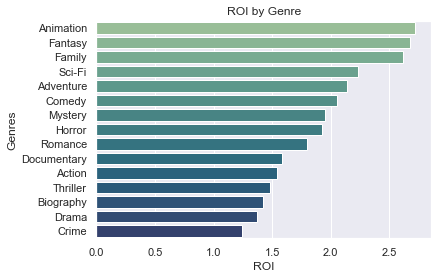

In [222]:
##plotting average ROI of by genre
sns.set_theme(style="darkgrid")
sns.barplot(
y=genres_ROI.index, x="ROI", 
palette='crest',
data=genres_grouped, orient="h").set(
ylabel='Genres', title = "ROI by Genre");

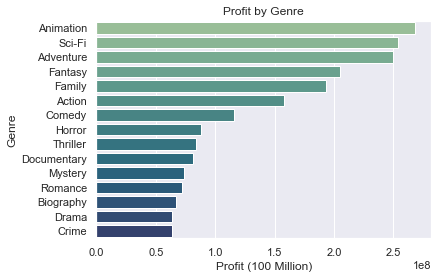

In [226]:
##plotting average profit(worldwide gross-production budget) by genre
sns.set_style('darkgrid')
sns.barplot(
y=genres_profit.index, 
x="profit",
palette='crest',
data=genres_profit, 
orient="h").set(
xlabel="Profit (100 Million)",
ylabel="Genre",
title="Profit by Genre");

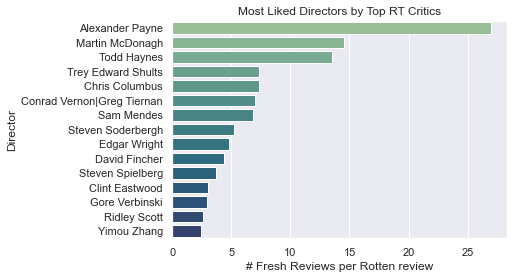

In [231]:
##plotting top 15 directors by # of "fresh" ratings per "rotten" rating
sns.set_style('darkgrid')
sns.barplot(
y=top_15_directors.index, 
x="fresh/rotten", 
palette='crest', 
data=top_15_directors, 
orient="h").set(
ylabel="Director",
xlabel="# Fresh Reviews per Rotten review",
title="Most Liked Directors by Top RT Critics");